# Step 1: Gathering data 

In [266]:
import json
import requests

Using provided instructions to pull data from legacy and other endpoints, as well as specifying the parameters such as desktop vs mobile and the time duration. These parameters will be used to call data from the API using a function

In [267]:
ENDPOINT_LEGACY = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

ENDPOINT_PAGEVIEWS = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

In [268]:
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }

params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                 "end" : "2016080100"
                    }

params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100", 
                    "end" : "2020100100"}
                            
params_pageviews_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2020100100'}

params_pageviews_mobile = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015070100",
                    "end" : '2020100100'}

In [298]:
headers = {
    'User-Agent': 'https://github.com/faryalusman',
    'From': 'fusman@uw.edu'
}

Creating a function to query the endpoint based on the specific parameters provided. 

In [300]:
def api_call(endpoint,parameters):
    """
    Function to call data based on endpoint and specific parameters
    """
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

Using the function to call the data for each of the 5 channels specified.

In [271]:
legacy_desktop = api_call(ENDPOINT_LEGACY, params_legacy_desktop)
legacy_mobile = api_call(ENDPOINT_LEGACY, params_legacy_mobile) 

pageviews_desktop =  api_call(ENDPOINT_PAGEVIEWS, params_pageviews_desktop)
pageviews_app =  api_call(ENDPOINT_PAGEVIEWS, params_pageviews_app)
pageviews_mobile =  api_call(ENDPOINT_PAGEVIEWS, params_pageviews_mobile)

Creating a function that when taking a file name and api queried data, will output the data
as a json locally with the same filename.

In [272]:
def save_json(filename, api_call):
    with open(filename, 'w') as outfile:
        json.dump(api_call, outfile)
        outfile.close()

Creating a dictionary of initially queried API data as well as desired JSON filenames that when looped over will save the data locally to the filename. Filenames are created as instructed

In [273]:
api_data_info = {
    'pagecounts_desktop_2007120100-2016080100.json':legacy_desktop, 
    'pagecounts_mobile_2007120100-2016080100.json':legacy_mobile, 
    'pageviews_desktop_2015070100-2020100100.json': pageviews_desktop, 
    'pageviews_mobile-app_2015070100-2020100100.json':pageviews_app, 
    'pageviews_mobile-site_2015070100-2020100100.json':pageviews_mobile
}

In [274]:
for json_file, api_data in api_data_info.items():
    save_json(json_file, api_data)

# Step 2: Processing the data

Creating a function that can load JSON data saved locally using a Pandas DataFrame format.

In [275]:
import pandas as pd

In [276]:
def json2df(json_filepath):
    with open(json_filepath, 'r') as file:
        json_data = json.load(file)['items']
        df = pd.json_normalize(json_data)
        file.close()
    return df

In [277]:
df_pc_desktop = json2df('pagecounts_desktop_2007120100-2016080100.json')
df_pc_mobile = json2df('pagecounts_mobile_2007120100-2016080100.json')

df_pv_desktop = json2df('pageviews_desktop_2015070100-2020100100.json')
df_pv_app = json2df('pageviews_mobile-app_2015070100-2020100100.json')
df_pv_mobile_web = json2df('pageviews_mobile-site_2015070100-2020100100.json')

Creating a function that can strip hours from the date and then convert it to a DateTime format.

In [278]:
def date_converter(data):
    time_col = 'timestamp'
    
    def string_formatter(time_string):
        #assert(len(time_string) == 10)
        if len(time_string) == 10:
            time_string = time_string[0:-2]
        else: 
            pass
        return time_string
    
    data['timestamp'] = data['timestamp'].apply(string_formatter)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    return data

Applying this date formatter to all the dataframes created above.

In [279]:
df_pc_desktop = date_converter(df_pc_desktop)
df_pc_mobile = date_converter(df_pc_mobile)

df_pv_desktop = date_converter(df_pv_desktop)
df_pv_app = date_converter(df_pv_app)
df_pv_mobile_web = date_converter(df_pv_mobile_web)

Creating a function for data processing that when given two pageviews mobile datasets (app data and website data), can combine them into one. As there are lots of unneeded columns in a pandas merge, this function also drops columns and renames others when apropriate. 

It also fills in missing values with 0 before creating a final column called 'pageview_mobile_views' that will the addition of both types of views.

In [280]:
def combine_mobile_data(app_data, website_data):
    """
    Function to combine pageviews mobile app and mobile site data into one 
    combined datframe.
    """
    drop_cols = ['project_y', 'agent_y', 'granularity_y', 
                 'views_x', 'views_y']
    
    combined = pd.merge(app_data, website_data, 
                       how='left', on='timestamp')
    combined.fillna(value=0)
    combined['pageview_mobile_views'] = combined['views_x'] + combined['views_y']
    
    combined.rename(columns= {'access_x':'access_app', 'access_y':'access_mobile-web'}, 
                   inplace=True)
    
    combined.drop(columns=drop_cols, inplace=True)
    combined.columns = combined.columns.str.rstrip('_x')
    
    assert(app_data.shape == website_data.shape)
    return combined

In [281]:
df_pv_mobile = combine_mobile_data(df_pv_app, df_pv_mobile_web)

Creating a function that can take in 4 datasets as arguments (two for each type of API endpoint and access type and combine them. It initally creates two datasets (for pageviews and the legacy endpoint) by using the pd.merge() function. It also does necessary preprocessing like filling missing values with 0, adding data and renaming / dropping extra columns. 

Then these two datasets are combined and merged into a single dataset, which is sorted by date and missing values are set to 0.

In [282]:
def api_data_combiner(data_pv_mobile, data_pv_desktop, 
                     data_pc_mobile, data_pc_desktop):
    """
    Creates one combined dataset of the 4 datasets, one for each combination
    of access / API Endpoint
    """
    # Preprocessing pageviews data 
    assert(data_pv_mobile.shape[0] == data_pv_desktop.shape[0])
    
    data_pv =  pd.merge(df_pv_mobile, df_pv_desktop, how='outer', 
                on=['timestamp'])
    data_pv.fillna(value=0, inplace=True)
    pv_cols = ['timestamp', 'pageview_mobile_views', 'views']
    data_pv = data_pv[pv_cols]
    data_pv.rename(columns={'views':'pageview_desktop_views'}, inplace=True)
    data_pv['pageview_all_views'] = data_pv['pageview_mobile_views'] + \
                                    data_pv['pageview_desktop_views']
    assert(data_pv.shape[0] == data_pv_mobile.shape[0])
    assert(data_pv.shape[0] == data_pv_desktop.shape[0])
     
        
     # Preprocessing legacy data   
    data_pc = pd.merge(df_pc_mobile, df_pc_desktop, how='outer', 
                on=['timestamp'])
    pc_cols = ['timestamp', 'count_x', 'count_y']
    data_pc = data_pc[pc_cols]
    data_pc.fillna(value=0, inplace=True)
    data_pc.rename(columns={'count_x':'pagecount_mobile_views', 
                           'count_y':'pagecount_desktop_views'},
                  inplace=True)
    data_pc['pagecount_all_views'] = data_pc['pagecount_mobile_views'] + \
                                    data_pc['pagecount_desktop_views']
    assert(data_pc.shape[0] == df_pc_desktop.shape[0])
    
    
    # Combining pageviews and legacy data
    pc_pv_combined = pd.merge(data_pc, data_pv, on=['timestamp'], 
                             how='outer')
    pc_pv_combined.fillna(value=0, inplace=True)
    pc_pv_combined.sort_values(by=['timestamp'], ascending=True, 
                              inplace=True)
    return pc_pv_combined 

In [283]:
aggregated_data = api_data_combiner(df_pv_mobile, df_pv_desktop, 
                 df_pc_mobile, df_pc_desktop)

Extracting Year and Month from the Timestamp

In [284]:
aggregated_data['Year'] = pd.DatetimeIndex(aggregated_data['timestamp']).year
aggregated_data['Month'] = pd.DatetimeIndex(aggregated_data['timestamp']).month

In [285]:
aggregated_data.head(2)

,timestamp,pagecount_mobile_views,pagecount_desktop_views,pagecount_all_views,pageview_mobile_views,pageview_desktop_views,pageview_all_views,Year,Month
22,2007-12-01,0.0,2.998332e+09,2.998332e+09,0.0,0.0,0.0,2007,12
23,2008-01-01,0.0,4.930903e+09,4.930903e+09,0.0,0.0,0.0,2008,1


In [286]:
final_data = aggregated_data.drop(columns=['timestamp'])

In [287]:
final_data.head()

,pagecount_mobile_views,pagecount_desktop_views,pagecount_all_views,pageview_mobile_views,pageview_desktop_views,pageview_all_views,Year,Month
22,0.0,2.998332e+09,2.998332e+09,0.0,0.0,0.0,2007,12
23,0.0,4.930903e+09,4.930903e+09,0.0,0.0,0.0,2008,1
24,0.0,4.818394e+09,4.818394e+09,0.0,0.0,0.0,2008,2
25,0.0,4.955406e+09,4.955406e+09,0.0,0.0,0.0,2008,3
26,0.0,5.159162e+09,5.159162e+09,0.0,0.0,0.0,2008,4


Saving this data locally as a .csv file using the name instructed.

In [288]:
csv_filename = 'en-wikipedia_traffic_200712-202008.csv'
final_data.to_csv(csv_filename)

# Step 3: Analyze the data 

Importing the necessary visualization libraries and using the data without the separate Year and Month columns for plotting convenience.

In [289]:
import matplotlib.pyplot as plt
import seaborn as sns

df = aggregated_data.drop(columns=['Year', 'Month'])

In [290]:
df.head()

,timestamp,pagecount_mobile_views,pagecount_desktop_views,pagecount_all_views,pageview_mobile_views,pageview_desktop_views,pageview_all_views
22,2007-12-01,0.0,2.998332e+09,2.998332e+09,0.0,0.0,0.0
23,2008-01-01,0.0,4.930903e+09,4.930903e+09,0.0,0.0,0.0
24,2008-02-01,0.0,4.818394e+09,4.818394e+09,0.0,0.0,0.0
25,2008-03-01,0.0,4.955406e+09,4.955406e+09,0.0,0.0,0.0
26,2008-04-01,0.0,5.159162e+09,5.159162e+09,0.0,0.0,0.0


In [291]:
sns.set_style('darkgrid') # Setting darker grid style

Showing overall combined traffic from all sources by adding the columns together

In [292]:
df['overall_traffic'] = df['pagecount_all_views'] + df['pageview_all_views']

Replacing 0s with nulls so that missing data are not plotted.

In [293]:
import numpy as np
df.replace(0, np.nan, inplace=True)

In [294]:
df.columns

Index(['timestamp', 'pagecount_mobile_views', 'pagecount_desktop_views',
       'pagecount_all_views', 'pageview_mobile_views',
       'pageview_desktop_views', 'pageview_all_views', 'overall_traffic'],
      dtype='object')

Creating a function that will convert Y axis labels to millions to supress scientific 
notation axis labelling.

In [295]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)
from matplotlib.ticker import FuncFormatter
formatter = FuncFormatter(millions)


Using instructions to plot data.

- Overall traffic plotted in black dashed line
- Mobile traffic (legacy endpoint) plotted in blue dashed line 
- Desktop traffic (legacy endpoint) plotted in green dashed line (with transparency so intersection with other lines is visible)
- Mobile traffic from the pageviews endpoint is plotted in blue straight line
- Desktop traffic from the pageviews endpoint is plotted in green straight line

Text(0.5, 1.0, 'Page Views on English Wikipedia')

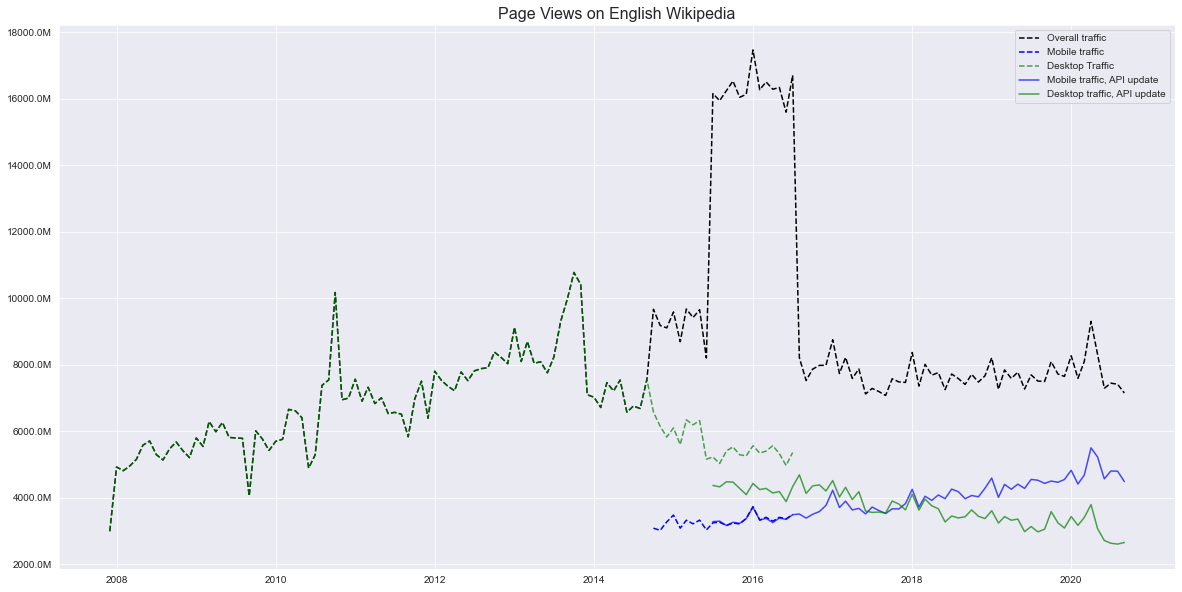

In [296]:
fig, ax = plt.subplots(figsize=(20,10))

# Applying the formatter function to fix the axis
ax.yaxis.set_major_formatter(formatter)


# Plotting time vs the data of interest in different colors and linestyles.
plt.plot(df['timestamp'], df['overall_traffic'], color='black', 
         linestyle='dashed', alpha=1, label='Overall traffic')
plt.plot(df['timestamp'], df['pagecount_mobile_views'], color='blue',linestyle='dashed', 
        label = 'Mobile traffic')
plt.plot(df['timestamp'], df['pagecount_desktop_views'], color='green',
         linestyle='dashed', alpha=0.7, label='Desktop Traffic')
plt.plot(df['timestamp'], df['pageview_mobile_views'], color='blue',
     alpha=0.7, label='Mobile traffic, API update')
plt.plot(df['timestamp'], df['pageview_desktop_views'], color='green',
     alpha=0.7, label='Desktop traffic, API update')

# Adding legend and title.
plt.legend()
plt.title('Page Views on English Wikipedia', fontdict={'fontsize':16})

In [297]:
fig.savefig('wikipedia_traffic.png')